In [1]:
1*2

2

In [1]:
import os
import GPUtil
import importlib

import pandas as pd
import os
import gc
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import torch
import gpytorch

from scipy.stats import pearsonr
from scipy.special import binom as binom
from sklearn.metrics import r2_score as r2
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split

In [3]:
import sys
sys.path.insert(1, '../')

import EpiK.models as models

In [4]:
output_device = 0
n_devices = torch.cuda.device_count()
models.set_params(output_device, n_devices)
print("number of GPUs = {}; output device = {}".
      format(n_devices, torch.cuda.current_device()))

number of GPUs = 8; output device = 0


In [5]:
from EpiK.functions import get_data, get_envs, set_data_path
set_data_path("../matsui_data/")

In [6]:
# training sizes
props = [.01, .05, .1, .2, .3, .4, .5, .6, .7, .8, .9, .95]

In [7]:
# check_point sizes
partitions = [2, 2, 2, 2, 4, 4, 4, 4, 16, 32, 64, 120]
pd.DataFrame({"props":props, "partitions":partitions}).to_csv("partition_sizes.csv", index=None)

In [8]:
partition_sizes = pd.read_csv("partition_sizes.csv")

### Data

In [9]:
env_list = get_envs()
env = env_list[5]

In [10]:
geno_t, pheno = get_data(env)

/blue/juannanzhou/EpiK/notebooks/../EpiK/functions.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  geno_t = torch.tensor(geno_t, dtype=torch.float)


In [12]:
inds_sub = np.where(np.array(pheno.pheno < -0.6) == False)[0]

### R2s for BGLR

In [17]:
data_path = "../BGLR/Data/"
result_path = "../BGLR/results/"

In [19]:
data_path + "test_list_", str(i), ".csv"

('../BGLR/Data/test_list_', '0', '.csv')

In [88]:
r2s = []

from scipy.stats import pearsonr

for i in range(12):
    test_list = pd.read_csv(data_path + "test_list_" + str(i) + ".csv", header=None).to_numpy().squeeze()
    y = np.array(pheno.pheno[test_list])
    pred = pd.read_csv(result_path + "BGLR_Matsui_pred_ " + str(i) + " .csv").to_numpy().squeeze()
#     r2s.append(pearsonr(y, pred)[0]**2)
    r2s.append(r2(y, pred))

In [105]:
i=1

test_list = pd.read_csv(data_path + "test_list_" + str(i) + ".csv", header=None).to_numpy().squeeze()
y = np.array(pheno.pheno[test_list])
pred = pd.read_csv(result_path + "BGLR_Matsui_pred_ " + str(i) + " .csv").to_numpy().squeeze()

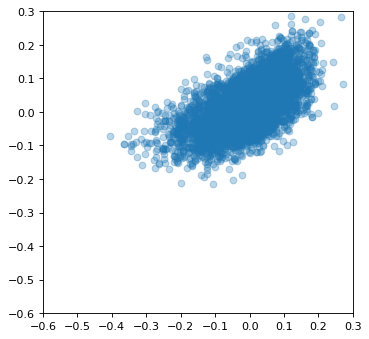

In [106]:
figure(figsize=(5, 5), dpi=80)
plt.plot(y, pred, 'o', alpha=.3)

# plt.scatter(y, pred, )
plt.xlim([-.6, .3])
plt.ylim([-.6, .3])
plt.show()

In [114]:
x = pred

A = np.vstack([x, np.ones(len(x))]).T

# Use numpy's least squares function
m, c = np.linalg.lstsq(A, y)[0]

print(m, c)
# 1.97 -0.11

# Define the values of our least squares fit
f = m * x + c

print(r2(y,f))


0.7927219249121525 -0.02282341112115468
0.37511750930289844


/scratch/local/48159256/ipykernel_26709/1714156884.py:6: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  m, c = np.linalg.lstsq(A, y)[0]


In [117]:
pearsonr(x, y)[0]**2

0.37511750930289744

### R2 curves

In [7]:
r2s_epik = pd.read_csv('r2s_epik.csv')
r2s_rbf = pd.read_csv('r2s_rbf.csv')

In [8]:
r2s_rbf['r2_score'] = [0.312839, 0.442586, 0.479176, 0.523877, 0.544006, 0.551005, 
                       0.559352, 0.566390, 0.573888, 0.550959, 0.574180, 0]

In [23]:
r2s_epik['props']

0     0.01
1     0.05
2     0.10
3     0.20
4     0.30
5     0.40
6     0.50
7     0.60
8     0.70
9     0.80
10    0.90
11    0.99
Name: props, dtype: float64

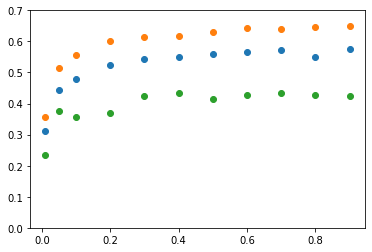

In [26]:
plt.scatter(r2s_rbf['props'][:-1], r2s_rbf['r2_score'][:-1])
plt.scatter(r2s_epik['props'][:-1], r2s_epik['r2'][:-1])
plt.scatter(r2s_epik['props'][:-1], r2s_bglrbb['r'][:-1]**2)


plt.ylim([0,.7])
plt.show()

In [5]:
r2s_bglrbb=pd.read_csv("../BGLR/results/BGLR_Matsui_results_pearsonr.csv")

In [152]:
data['id'] = data.index

In [271]:
np.random.seed(123)
df = pd.DataFrame({"r0" : dict(zip(range(11),r2s_epik['r2'][:-1])),
                   "r1" : dict(zip(range(11),r2s_rbf['r2_score'][:-1])),
                   "r2" : dict(zip(range(11),r2s_bglrbb['r'][:-1]**2)),
                   "props" :dict(zip(range(11), r2s_rbf['props'][:-1]))})

df["id"] = df.index

plotdata = pd.wide_to_long(df, ["r"], i="id", j="Model")

In [272]:
plotdata.reset_index(inplace=True)

In [273]:
plotdata['Model'] = plotdata['Model'].replace({0: "EpiK", 1: "Gaussian", 2: "Additive"})

In [268]:
# plotdata = plotdata.rename(columns={"props": "Proportion of training data", 'r': 'R'})

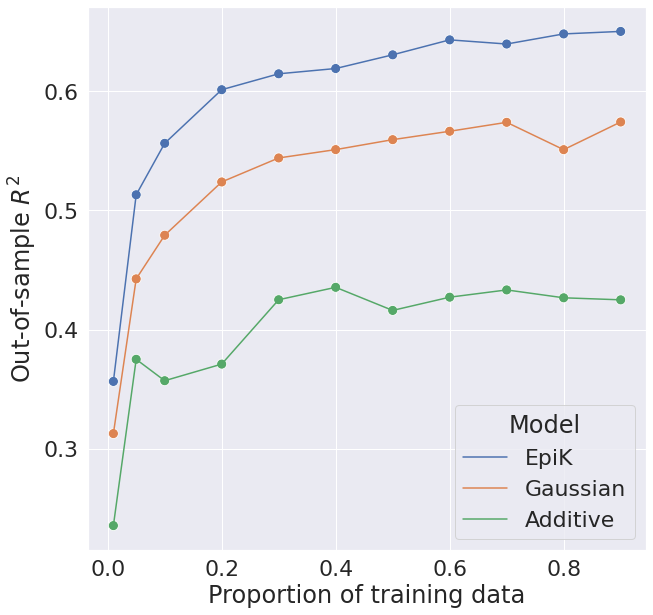

In [289]:
import matplotlib as mpl
import seaborn as sns

mpl.rc("figure", figsize=(10, 10))
sns.set(font_scale=2)

g = sns.lineplot(data=plotdata, x='props', y="r", hue="Model")
g.set(xlabel="Proportion of training data", ylabel='Out-of-sample $R^2$')
# g.grid(False)

g_dots = sns.scatterplot(data=plotdata, x='props', y="r", hue="Model", legend=False, s=100)


plt.show()

# plt.legend(title='Smoker', loc='lower right', labels=['Additive', 'Gaussian', 'EpiK'])